In [3]:
# imports
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import metrics
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
import keras
from keras.callbacks import ModelCheckpoint
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score

In [4]:
df = pd.read_csv("methane_monthly.csv")
df["time"] = df["month"].astype(str) + "/" + df["year"].astype(str)
df = df.drop(['decimal', 'month', 'year'], axis=1)
df["time"] = pd.to_datetime(df["time"])

target_col = "average"

# MinMaxScaler to scale all values between 0 and 1
scaler = MinMaxScaler()

# Only column requiring scaling is the monthly average
df[[target_col]] = scaler.fit_transform(df[[target_col]])

# Creating a numeric index
df.index = df.index * 0.1 + 1

C:\Users\tomco\AppData\Local\Temp\ipykernel_39700\4155340899.py:4: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df["time"] = pd.to_datetime(df["time"])


In [5]:
# Doing an 80/20 split
# for train/test
cutoff = int(len(df) * 0.80)

# train data
X_train = df.index[0:cutoff]
y_train = df[target_col].iloc[0:cutoff]

# test data
X_test = df.index[cutoff:]
y_test = df[target_col].iloc[cutoff:]

# convert to NumPy array-format (expected by the generators)
X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)

# This part doesn't seem to be necessary per se, but I did get very bad looking
# loss plots after the training without this part, despite decent predictions/extrapolation
n_features = 1
train_series = y_train.reshape((len(y_train), n_features))
test_series = y_test.reshape((len(y_test), n_features))

In [6]:
# TimeseriesGenerators, for train and test
from keras.preprocessing.sequence import TimeseriesGenerator

# This is the number of values each timestep makes up
# so with 1000 points total, look_back being 20 => 50 time steps
look_back  = 16

# using 1 => using time steps
# anything above 1 => windowing (instead of time steps)
window_size = 1

# the amount of data fed into the neural network while training
# the bigger it is, the faster the training
# but with forecasts it also affects the performance
batch_size = 1

train_generator = TimeseriesGenerator(train_series, train_series,
                                      length        = look_back, 
                                      #sampling_rate = 1,
                                      stride        = window_size,
                                      batch_size    = batch_size)

test_generator = TimeseriesGenerator(test_series, test_series,
                                      length        = look_back, 
                                      #sampling_rate = 1,
                                      stride        = window_size,
                                      batch_size    = batch_size)

In [7]:
from IPython.display import clear_output

# Custom Callback for plotting the training data in real-time
class CustomCallback(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        
        # Make lists of the finished epochs and training metrics
        self.x = []
        self.losses = []
        self.val_losses = []

    def on_epoch_end(self, epoch, logs={}):
        # after each epoch, append the metrics to the lists
        self.x.append(epoch)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        
        # Clear output from previous rendering of the plot
        # And re-plot the loss & val_loss
        clear_output(wait=True)
        plt.plot(self.losses, label="loss")
        plt.plot(self.val_losses, label="val_loss")
        plt.legend()
        plt.show()

In [6]:
'''import keras_tuner
from keras import layers


# the neural network architecture, some layers are set
# while others are variable and changed according to the keras tuner
def build_model(hp):
    model = keras.Sequential()
    # Input layer is set to 32 nodes
    #model.add(layers.LSTM(32, activation="relu", input_shape=(look_back, n_features,), return_sequences=True))

    # Here the tuner tries out different combinations of layer and neuron numbers
    for i in range(hp.Int("num_layers", 1, 1)):
        model.add(
            layers.LSTM(
                # Tune number of units separately.
                units=hp.Int(f"units_{i}", min_value=4, max_value=128, step=4),
                activation=hp.Choice("activation", ["relu"]),
            )
        )

    # Dropout layers are also included some of the time (not in each run)
    if hp.Boolean("dropout"):
        model.add(layers.Dropout(rate=0.2))

    # output layer is always the same (regression)
    model.add(layers.Dense(1))

    learning_rate = hp.Float("lr", min_value=1e-5, max_value=1e-2)

    # compile all and return model for tuning
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
        loss="mse"
    )

    return model

build_model(keras_tuner.HyperParameters())

# we need to define the build_model -function
# that has the approximate structure of the neural network
# and determines which details the keras tuner is going to experiment on

tuner = keras_tuner.RandomSearch(
    hypermodel=build_model,
    objective="val_loss",
    max_trials=5,
    executions_per_trial=3,
    overwrite=True,
    directory="optimizations",
    project_name="methane_concentration",
)

# Executing the search, but of course higher complexity and number of epochs
# will make the training slower and more resource-intensive
tuner.search(train_generator, epochs=100, validation_data=(test_generator))

# Getting the best 2 models
models = tuner.get_best_models(num_models=2)

# Summary for the best model
best_model = models[0]
best_model.summary()'''

'import keras_tuner\nfrom keras import layers\n\n\n# the neural network architecture, some layers are set\n# while others are variable and changed according to the keras tuner\ndef build_model(hp):\n    model = keras.Sequential()\n    # Input layer is set to 32 nodes\n    #model.add(layers.LSTM(32, activation="relu", input_shape=(look_back, n_features,), return_sequences=True))\n\n    # Here the tuner tries out different combinations of layer and neuron numbers\n    for i in range(hp.Int("num_layers", 1, 1)):\n        model.add(\n            layers.LSTM(\n                # Tune number of units separately.\n                units=hp.Int(f"units_{i}", min_value=4, max_value=128, step=4),\n                activation=hp.Choice("activation", ["relu"]),\n            )\n        )\n\n    # Dropout layers are also included some of the time (not in each run)\n    if hp.Boolean("dropout"):\n        model.add(layers.Dropout(rate=0.2))\n\n    # output layer is always the same (regression)\n    model

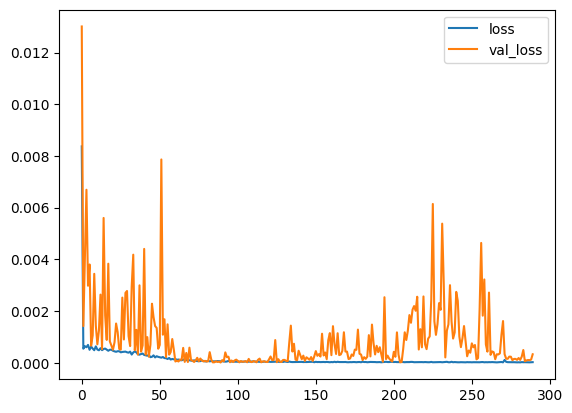

370/370 [==============================] - 3s 7ms/step - loss: 2.2290e-05 - val_loss: 3.2656e-04
Epoch 290: early stopping


In [7]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import LSTM
from keras.layers import SimpleRNN

# Create an LSTM/RNN network
model = Sequential()

# Single layer architectures can be done as following,
# options here are LSTM and RNN
# return sequences should not be used in the final LSTM layer
# so with multiple layers, it should be set to true for all but the last layer
#model.add(LSTM(64, activation="relu", input_shape=(look_back, n_features)))
#model.add(SimpleRNN(64, activation="relu",input_shape=(look_back, n_features)))

model.add(LSTM(56, activation="relu", input_shape=(look_back, n_features), return_sequences=True)),
model.add(LSTM(8, activation="relu")),
model.add(Dense(1)),
model.compile(optimizer='adam', loss='mse')

mc = ModelCheckpoint("lstm_best_model.keras", monitor='val_loss', mode='min', save_best_only=True)

# Reduce the learning rate on plateau
rd_lr_op = keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=20, min_lr=0.0001)

# Early stop
early_stop = keras.callbacks.EarlyStopping(monitor="val_loss", patience=200, verbose=1)
create_plots = CustomCallback()

# Creating a list of callbacks
callbacks = [mc, early_stop, create_plots]

# Model training, also already defining the validation data for the metrics later
model.fit(train_generator,epochs=1000, callbacks=callbacks, verbose=1, validation_data=test_generator)

In [8]:
# load the best model from the model checkpoint
model = keras.models.load_model("lstm_best_model.keras")

# Create test predictions
test_predictions  = model.predict(test_generator)



81/81 [==============================] - 1s 2ms/step


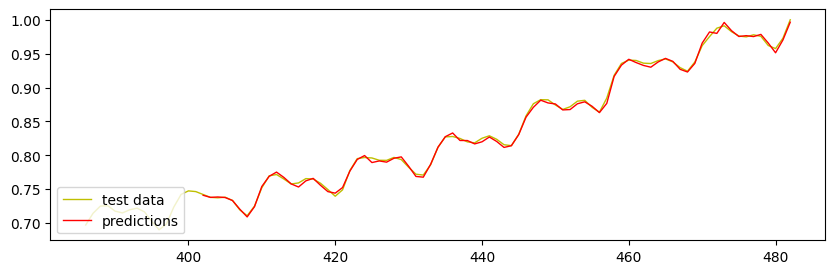

In [9]:
# Comparing predictions to testing data
#x1 = np.arange(0,len(y_train))
x2 = np.arange(len(y_train),len(y_train) + len(y_test))
x3 = np.arange(len(y_train) + look_back, len(y_train) + len(y_test))

fig, ax = plt.subplots(1, 1, figsize=(10, 3))

# Hiding the training data to get a closer look 
# and see how well predictions match the data
#ax.plot(x1,y_train, lw=1, label='train data')
ax.plot(x2,y_test, lw=1, c='y', label='test data')
ax.plot(x3,test_predictions, lw=1, c='r', label='predictions')
ax.legend(loc="lower left")
plt.show()

In [10]:
# Error metrics
# TF evaluation metrics
# Train/test loss
result_train = model.evaluate(train_generator, verbose=0)
result_test = model.evaluate(test_generator, verbose=0)

print(f"Training loss: {result_train:.20f}")
print(f"Testing loss: {result_test:.20f}")
print(f"Difference: {abs(result_train - result_test):.20f}\n")


actual_y_test = np.concatenate([y for x, y in test_generator])
errors = np.abs(actual_y_test - test_predictions)
mape = np.mean(errors / actual_y_test) * 100

# MAPE - Mean average precision error
print("MAPE (mean average precision error):")
print(f"{round(mape, 2)} %")

# MAE - Mean absolute error
print("\nMAE")
print(round(metrics.mean_absolute_error(actual_y_test , test_predictions), 2), " units")

# MSE - Mean square error
print("\nMSE")
print(round(metrics.mean_squared_error(actual_y_test, test_predictions), 2), " units^2")

# RMSE - Root mean square error
print('\nRMSE:')
print(round(np.sqrt(metrics.mean_squared_error(actual_y_test , test_predictions)), 2), " units")

# R-squared
print('\nR-squared:')
print(round(metrics.r2_score(actual_y_test , test_predictions), 2))

# These metrics look excellent


Training loss: 0.00003041624950128607
Testing loss: 0.00000991539582173573
Difference: 0.00002050085367955035

MAPE (mean average precision error):
0.3 %

MAE
0.0  units

MSE
0.0  units^2

RMSE:
0.0  units

R-squared:
1.0


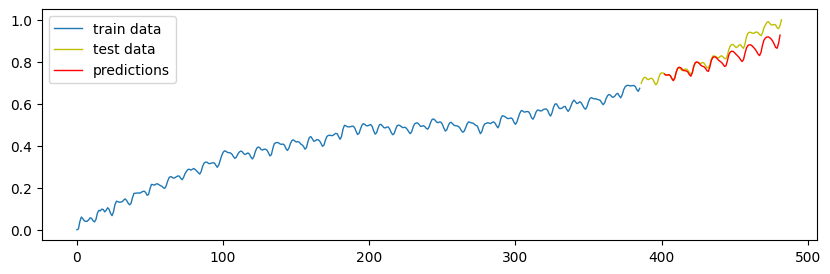

In [11]:
# Extrapolation test
extrapolation = list()
seed_batch    = y_test[:look_back].reshape((1,look_back, n_features))
current_batch = seed_batch

# Extrapolate the next n values
n = 80
for i in range(n):
    predicted_value = model.predict(current_batch, verbose=0)[0]
    extrapolation.append(predicted_value) 
    current_batch = np.append(current_batch[:,1:,:],[[predicted_value]],axis=1)

# and overlay them with the train/test data
x1 = np.arange(0, len(y_train))
x2 = np.arange(len(y_train), len(y_train) + len(y_test))
x3 = np.arange(len(y_train) + look_back, len(y_train) + len(extrapolation) + look_back)

fig, ax = plt.subplots(1, 1, figsize=(10, 3))

# It's also easy to hide the training data to inspect the
# the predictions vs. test data more closely
ax.plot(x1, y_train, lw=1, label='train data')
ax.plot(x2, y_test, lw=1, c='y', label='test data')
ax.plot(x3, extrapolation, lw=1, c='r', label='predictions')
ax.legend(loc="upper left")
plt.show()

In [12]:
# Function to try out extrapolation with different starting points and look backs

def extrapolate(data, start, look_back, num_preds):
    # EXTRAPOLATION TEST 
    extrapolation = list()
    seed_batch    = data[start-look_back:(start)].reshape((1,look_back, n_features))
    current_batch = seed_batch

    # extrapolate the next n values
    for i in range(num_preds):
        predicted_value = model.predict(current_batch, verbose=0)[0]
        extrapolation.append(predicted_value) 
        current_batch = np.append(current_batch[:,1:,:],[[predicted_value]],axis=1)

    if len(data) == len(y_test):
        start = start + len(y_train)

    end = start + len(extrapolation)

    # Plotting the train/test data and overlaying the extrapolated data
    x1 = np.arange(0, len(y_train))
    x2 = np.arange(len(y_train), len(y_train) + len(y_test))
    x3 = np.arange(start, end)

    fig, ax = plt.subplots(1, 1, figsize=(10, 3))

    # It's also easy to hide the training data to inspect the
    # the predictions vs. test data more closely
    ax.plot(x1, y_train, lw=1, label='train data')
    ax.plot(x2, y_test, lw=1, c='y', label='test data')
    ax.plot(x3, extrapolation, lw=1, c='r', label='predictions')
    ax.legend(loc="upper left")
    plt.show()

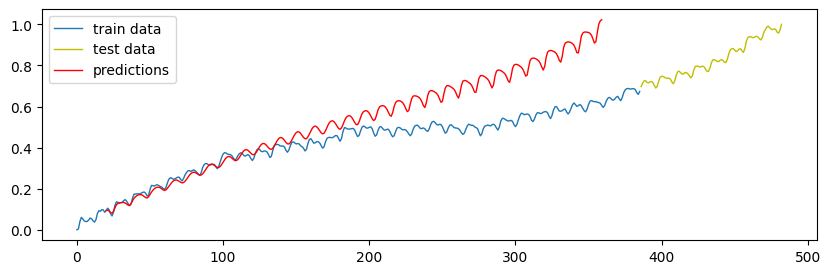

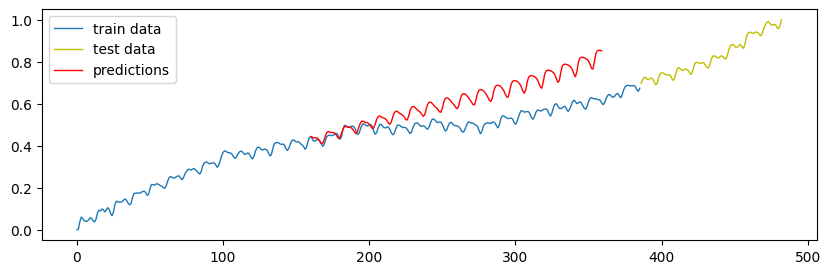

In [14]:
# Testing different starting points for the extrapolation
# Extrapolating from start 20, look_back 16 and extrapolating 340 points into the future
extrapolate(y_train, 20, 16, 340)

# Just 300 points but starting from 60
extrapolate(y_train, 160, 16, 200)

# Not that good for some reason, basically just giving mostly linear predictions
# but at least somewhat keeping the reoccurring pattern
# Maybe okay for short-term predictions, which goes against what one would expect for an LSTM model

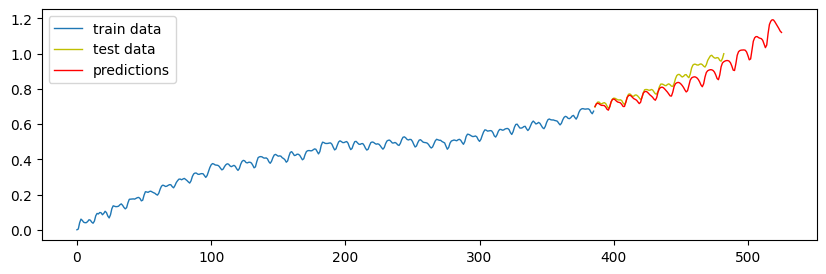

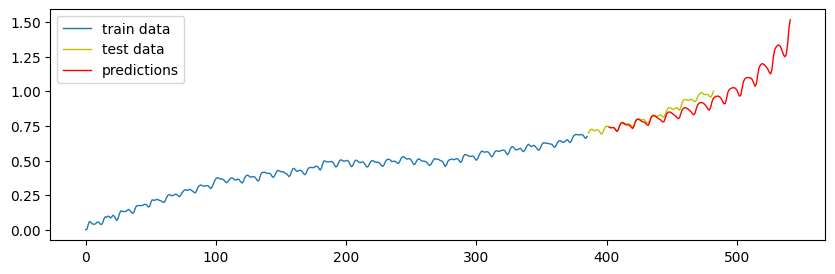

In [17]:
# Some more testing with mediocre results
# Interesting with the test data (slightly later data)
# the model predicts a more exponential curve
extrapolate(y_train, 386, 16, 140)
extrapolate(y_test, 16, 16, 140)

# Changing the look back at all basically breaks the model completely
# that's something to take into account

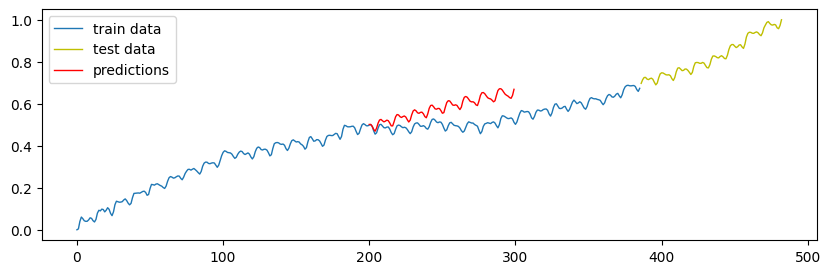

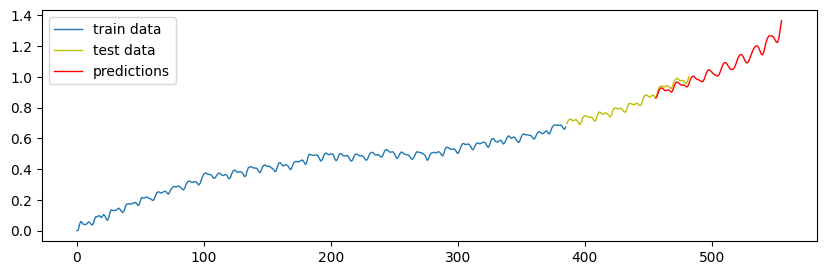

In [18]:
# Some more examples, first one bad, second one quite good
extrapolate(y_train, 200, 16, 100)
extrapolate(y_test, 70, 16, 100)

In [ ]:
# This is about as good as I could get this LSTM-model to get
# what is positive here is that the amplitude of the "wave" stays quite consistent
# and the increasing trend is predicted correctly
# it undershoots a bit (rather linear than the exponential behaviour of the test data)
# and the extrapolated signal becomes too smooth
# but otherwise I think it's a solid result

In [ ]:
# After testing predictions/extrapolation for both models, I would say that in this case the RNN model performs quite a bit better
# This is likely due to the dataset, as I tried out quite a few optimisation methods for both
# Keras tuner was interesting to use and took quite a bit of time here,
# but unfortunately it wasn't terribly helpful as the best results were for simple layer structures similar to what I already had
# Still, it allowed me to take some time off testing manually and just leave the computer running while I could take care of other things
# Some behaviour that both models exhibit with extrapolation is the further the points are from the starting point, the smoother it gets
# So in a way it could be used to add an uncertainty range based on the smoothness of the graph
# Although it probably would be better to just test the model and create uncertainty bands with a mathematical function

In [12]:
# Final thoughts and comments

# In this file I focused mostly on the LSTM-style neural network and while the predictions for the test data
# get pretty good, extrapolating from data into the future is really wonky
# I think what makes it difficult is partially how big the look back is
# With look_back = 16, the model can't get much of an idea of the overall trend in the data
# so the extrapolated slope often overshoots/undershoots
# But changing the look back does not work very well for extrapolation, I guess
# the model would need to be retrained for it

# As for the actual repeating pattern, the model can end up attenuating or amplifying it
# resulting in either a disappearing signal or one that becomes way too extreme
# If none of those scenarios happen, then one might have a somewhat promising model
# Although it is still a big question mark how it does in real-world testing

# I think this shows really well that things can seem way simpler than they are
# if you have access to the actual data/outcome after the fact
# But if it's about making a prediction without any knowledge of the future
# a machine learning model can and will do many of the same mistakes a human does
# They only work if there really is an underlying principle to extrapolate from
# which is possible to capture through the noise
# A good example is the stock market - it looks reasonable to make a prediction if you look at historical data
# but that is because we have knowledge of what happened
# To someone 20 years ago it would have been difficult to predict just how big Google, Amazon and co. would become
# and that other companies like yahoo or myspace would fade into obscurity
# But to most people nowadays it "feels" obvious
# As they say: hindsight is 20/20 (but time series forecasting isn't)

# On the other hand, with something like global warming there is a clear and continuous trend
# which is dominated by a clear causal relationship which can be simulated scientifically

# However, there are always boundaries where the main factor affecting a change can be overtaken by another factor starting to dominate
# I can explain what I mean with an example:
# e.g. someone is measuring the inside temperature of an egg being boiled in a pot of water
# at first the temperature will gradually increase because of the heat provided by the cooking plate
# until the water temperature reaches 100°C, which is when the water can't heat up more without evaporating
# so the egg can't heat up further, until the water is completely evaporated 
# and the egg is in direct contact with the metal pot, after which it can continue heating up further

# The same way as my crude example illustrates, there are certain ranges 
# where data can be used to come to a mostly accurate conclusion
# and an ML model can be trained to make predictions within those ranges
# But if the real world scenarios change enough to diverge from those ranges/behaviours
# the model's accuracy will break down